In [15]:
pyenv install 3.9.9

SyntaxError: invalid syntax (<ipython-input-15-febaa64e61e4>, line 1)

In [ ]:
import sklearn
print(sklearn.__version__)

In [8]:
from scipy.ndimage import gaussian_filter1d

def denoise_and_norm(data: np.ndarray, wavelength: np.ndarray, denoising: bool, normalising: bool, sigma_nm: float = 7.,
                     normalised_at_wvl: float = 550.) -> np.ndarray:
    if np.ndim(data) == 1:
        data = np.reshape(data, (1, len(data)))

    if denoising:
        nm_to_px = 1. / (wavelength[1] - wavelength[0])  # conversion from nm to px
        correction = gaussian_filter1d(np.ones(len(wavelength)), sigma=sigma_nm * nm_to_px, mode="constant")
        data_denoised = gaussian_filter1d(data, sigma=sigma_nm * nm_to_px, mode="constant") / correction
    else:
        data_denoised = data

    # Normalised reflectance
    if normalising:
        fun = interp1d(wavelength, data_denoised, kind="cubic")  # v_final differs from v
        v_norm = np.reshape(fun(normalised_at_wvl), (len(data_denoised), 1))
    else:
        v_norm = 1.

    #return data_denoised / v_norm
    return (data_denoised / v_norm).flatten()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
#from modules.utilities_spectra import denoise_and_norm

catalogue = pd.read_excel("data_all_H_laser.xlsx",
                          index_col=None,
                          header=0,
                          na_values=["NA"],
                          engine="openpyxl")

sample_names = np.array(catalogue["Sample name"], dtype=str)
ET_1AU = np.array(catalogue["ET_1AU"], dtype=np.float32)
type = np.array(catalogue["type"], dtype=str)
irradiation = np.array(catalogue["Irradiation"], dtype=int)
log_ET_1AU = np.reshape(np.log10(np.array(catalogue["ET_1AU"], dtype=np.float32) + 1), (-1, 1))
group = np.array(catalogue["group"], dtype=int)

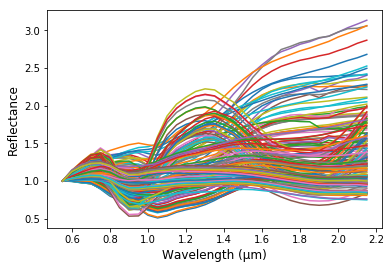

In [10]:
wavelengths_new = np.arange(550., 2200., 50.)

input_data = np.zeros((len(sample_names), len(wavelengths_new) + 1), dtype=np.float32)  # +1 for band slope

for i, sample_name in enumerate(sample_names):
    # Read the spectrum data from the CSV file
    spectra = pd.read_csv("Data/" + sample_name + ".csv", header=1)

    wavelengths, spectra = spectra["W"].to_numpy() * 1000., spectra["R"].to_numpy()

    # Interpolate the spectra onto the new wavelengths using cubic interpolation (by ignoring the duplicate values)
    unique_wavelengths, unique_indices = np.unique(wavelengths, return_index=True)
    unique_spectra = spectra[unique_indices]

    interp_func = interp1d(unique_wavelengths, unique_spectra, kind="linear")
    interpolated_spectra = interp_func(wavelengths_new)

    # Call the denoise function
    denoised_normalized_data = denoise_and_norm(interpolated_spectra, wavelengths_new, denoising=True, normalising=True)

    input_data[i, :-1], input_data[i, -1] = denoised_normalized_data, irradiation[i]
    # input_data[i,] = denoised_normalized_data

    plt.plot(wavelengths_new/1000, denoised_normalized_data)

plt.xlabel("Wavelength (µm)", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
savefig_kwargs = {"bbox_inches": "tight",
                  "pad_inches": 0.05,
                  "dpi": 100}  # dpi only for jpg/png figures
plt.savefig('Samples.png', format='png', **savefig_kwargs)


In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle

from keras.layers import Dense, Conv1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor,GradientBoostingRegressor,RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import r2_score
from sklearn.utils.validation import check_is_fitted

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
y_pred = []
y_true = []

actual_values = []
predicted_values = []

mse_values = []
Xypred_msc = []
ytest_msc = []
# Initialize lists to store data
actual_predicted_data = []
all_predicted_values = []
all_test_indices = []
all_y_test = []
error = []
actual_values_NoHe = []
absolute_errors_all = []
predicted_cnn = []

# To store loss history
training_loss = []
validation_loss = []

In [ ]:
def create_cnn_model_1(input_shape,learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=2, activation="relu", padding="same"))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(1, activation="relu"))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mean_absolute_error"])
    return model

In [ ]:

class CNNRegressor(KerasRegressor, RegressorMixin, BaseEstimator):
    def __init__(self, input_shape, learning_rate=0.001, epochs=800, batch_size=32, verbose=1, **kwargs):
        super().__init__(**kwargs)
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def _build_fn(self):
        return self._create_cnn_model()

    def _create_cnn_model(self):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(Conv1D(filters=32, kernel_size=2, activation="relu", padding="same"))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(1, activation="relu"))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mean_absolute_error"])
        return model

    # Define the sklearn tags for this custom regressor
    @staticmethod
    def __sklearn_tags__():
        return {"estimator_type": "regressor"}

    def fit(self, X, y=None, **kwargs):
        return super().fit(X, y, **kwargs)

    def predict(self, X, **kwargs):
        return super().predict(X, **kwargs)

In [ ]:
# Initialize arrays to store predictions for each iteration
all_predictions_df = pd.DataFrame()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for iteration in range(30):

    #iteration_predicted_values = []
    iteration_predicted_values = np.zeros(len(sample_names))  # Initialize with zeros

    for train_index, test_index in skf.split(input_data, group):
        X_train, X_test, y_train, y_test = (input_data[train_index], input_data[test_index],
                                            log_ET_1AU[train_index], log_ET_1AU[test_index])

        # Create an ensemble of neural networks using a VotingRegressor
        ensemble_model = VotingRegressor(
            estimators=[
                ('cnn', CNNRegressor(input_shape=(X_train.shape[1], 1),epochs=800, batch_size=32, verbose=1)),
                ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.4, random_state=42)), 
                ('knn', KNeighborsRegressor(n_neighbors=3)),
                ('etr', ExtraTreesRegressor(n_estimators=100, random_state=42)),
                ('rft', RandomForestRegressor(n_estimators=100, random_state=42))
            ],
            weights=[2, 4, 1, 5, 1], 
            n_jobs=5
        )

        print("Validating estimators within VotingRegressor...")
        ensemble_model.fit(X_train, y_train.ravel())
        check_is_fitted(ensemble_model, "estimators_")
        print("All estimators are fitted correctly.")

        y_pred_ensemble = ensemble_model.predict(X_test)

        actual_values.extend(y_test)
        predicted_values.extend(y_pred_ensemble)

        y_pred_scaled = 10**y_pred_ensemble-1
        y_test_scaled = 10*y_test-1

        # Align predictions with the correct sample indices
        for idx, prediction in zip(test_index, y_pred_scaled):
            iteration_predicted_values[idx] = prediction

    # Add this iteration's predictions to the DataFrame
    all_predictions_df[f"Iteration {iteration + 1}"] = iteration_predicted_values

# Extract true values aligned with the sample names
true_values = ET_1AU.ravel()  # Assuming log_ET_1AU contains the true values for all samples
#sample_names_list = list(sample_names)  # Ensure sample names match for alignment
all_predictions_df["True Value"] = true_values

# Calculate mean and standard deviation for each sample
all_predictions_df["Mean Prediction"] = all_predictions_df.iloc[:, 1:].mean(axis=1)  # Mean across all iterations
all_predictions_df["Standard Deviation"] = all_predictions_df.iloc[:, 1:].std(axis=1)  # Std deviation across all iterations

# Save all predictions, mean, and standard deviation to an Excel file
output_file = "predictions_with_stats.xlsx"
all_predictions_df.to_excel(output_file, index=False)

print(f"Predictions for all iterations saved to {output_file}")


In [ ]:
selected_types_irr = ['1', '2', '3', '10', '11', '12']
# Color mapping for the bus types
color_tax = {'1': 'green',
             '2': 'green',
             '3': 'green',
             '10': 'black',
             '11': 'black',
             '12': 'black',
             }

mse_En = mean_squared_error(all_predictions_df["True Value"], all_predictions_df["Mean Prediction"], squared=False)

r2_En = r2_score(actual_log, predicted_En_log)

fig = plt.figure(figuresize=(8,8))

for i in selected_types_irr:
    # Ensure comparison is done elementwise
    mask1 = irradiation_en == i

    plt.errorbar(all_predictions_df["True Value"][mask1], all_predictions_df["Mean Prediction"][mask1], yerr=all_predictions_df["Standard Deviation"][mask1], capsize=1, fmt='o', linewidth=0.5,
                 markersize=3, label=i, color=color_tax[i])

    
# Color-coded entries for different types
ion = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=5, label='H$^+$ irradiation')
laser = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Laser irradiation')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-1, 10**10)
plt.xlim(1e-1, 10**10)
plt.title('Ensemble model', fontsize=10)
plt.plot(x_vals, x_vals, 'r-', zorder=2, linewidth=1, label='No error')
pltplot(x_vals, 4 * x_vals, 'b--', zorder=1, linewidth=1, label='4 factor error')
plt.plot(x_vals, x_vals / 4, 'b--', zorder=1, linewidth=1)

plt.plot(x_vals, 2 * x_vals, '--', color='orange', zorder=1, linewidth=1, label='2 factor error')
plt.plot(x_vals, x_vals / 2, '--', color='orange',zorder=1, linewidth=1)

#ax1.set_xlabel('True exposure time (years)', fontsize=12)
plt.ylabel('Predicted surface age (years)', fontsize=10)

plt.text(10**7, 7, f"R$^2$: {r2_En:.4f}", fontsize=10, ha='left')
plt.tick_params(axis='both', which='major', length=6, width=1, labelsize=9)
plt.legend(handles=[ion, laser],loc='best', frameon=True, fontsize=10)
plt.set_xlim(0.5, 10**10)
plt.set_ylim(0.5, 10**10)
plt.set_aspect('equal')

plt.legend()
plt.subplots_adjust(hspace=0.05, wspace=0.05)


# Save the plot as PDF
savefig_kwargs = {"bbox_inches": "tight",
                  "pad_inches": 0.05,
                  "dpi": 100}  # dpi only for jpg/png figures
plt.savefig('En_validation_plot.png', format='png', **savefig_kwargs)


plt.show()